# Analyzing business potential of areas in Pune, India

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim,Pelias
import requests

In [2]:
def get_coordinates(address_list):
    geolocator = Nominatim(user_agent="wain")
    locations = pd.DataFrame(columns=['Area name', 'latitude', 'longitude'])
    for address in address_list:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = 'Address not found'
            longitude = 'Address not found'
        locations = locations.append(
            {
                'Area name': address,
                'latitude': latitude,
                'longitude': longitude
            },
            ignore_index=True)
    return locations

In [3]:
address = ['Shankar Kalat nagar','Pimpri-Chinchwad','Aundh,Pune','Kothrud','Koregaon Park']
locations = get_coordinates(address)
locations

,Area name,latitude,longitude
0,Shankar Kalat nagar,18.604093,73.754065
1,Pimpri-Chinchwad,18.627929,73.800983
2,"Aundh,Pune",18.561883,73.810196
3,Kothrud,18.503889,73.807673
4,Koregaon Park,18.537553,73.893925


In [4]:
# hide this cell
# credential foursquare API
CLIENT_ID = 'DMMNDCKP4HCEBKNG0OZUKP4HQ4G2ARKETXFJLZOI1DY001IT' # your Foursquare ID
CLIENT_SECRET = 'BNOTBJCDHCHRJ3Z1EAMLB0TXSCA4RUH1HSABRTIV33ERSMAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [5]:
import json
from pandas.io.json import json_normalize

In [6]:
def get_venues(lat, lon):
    LIMIT = 100
    radius = 5000
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)  # flatten JSON
        filtered_columns = [
            'venue.name', 'venue.categories', 'venue.location.lat',
            'venue.location.lng'
        ]
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(
            get_category_type, axis=1)
        nearby_venues.columns = [
            col.split(".")[-1] for col in nearby_venues.columns
        ]

    except:
        return None

    return nearby_venues

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
df_venues = pd.DataFrame(columns=['name','categories','lat','lng'])
for i in range (0,len(locations.index)):
    df_venues = df_venues.append(get_venues(locations.latitude[i],locations.longitude[i]))
    
df_venues.shape

(498, 4)

In [9]:
df_venues.head()

,name,categories,lat,lng
0,Sayaji,Hotel,18.599535,73.754995
1,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,Courtyard by Marriott,Hotel,18.591527,73.746831
4,Little Italy,Italian Restaurant,18.591513,73.743668


In [10]:
df_venues = df_venues.drop_duplicates()

In [11]:
df_venues.shape

(429, 4)

In [12]:
import folium

In [13]:
map_ = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, Categories, name in zip(df_venues['lat'], df_venues['lng'], df_venues['categories'], df_venues['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

In [14]:
df_venues.to_csv('venues_all.csv',index=False)

In [15]:
Clus_dataSet = df_venues[['lat','lng']] 
Clus_dataSet.head()

,lat,lng
0,18.599535,73.754995
1,18.591192,73.752440
2,18.599390,73.755090
3,18.591527,73.746831
4,18.591513,73.743668


In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from folium import plugins
import matplotlib.pyplot as plt

In [17]:
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)
Clus_dataSet[0:5]

array([[ 0.85212735, -1.23989592],
       [ 0.65993112, -1.29012161],
       [ 0.84876854, -1.23802537],
       [ 0.66765555, -1.40034594],
       [ 0.66732645, -1.46251123]])

In [18]:
dist = []
list_k = list(range(1, 12))      # list of values of k to test for

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet)
    dist.append(km.inertia_)   

Text(0, 0.5, 'Sum of squared distance')

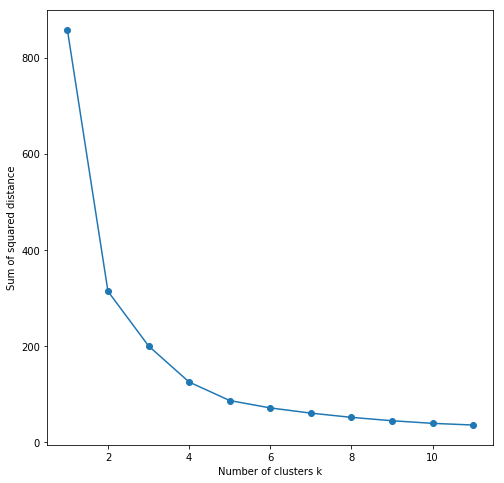

In [19]:
# Plot dist against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, dist, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

In [20]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 2, 3, 0, 0, 3,
       0, 0, 2, 2, 3, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3,
       3, 3, 2, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 2,
       2, 3, 3, 2, 3, 3, 3, 0, 0, 0, 3, 3, 2, 0, 0, 3, 3, 0, 0, 3, 3, 3,
       3, 3, 3, 2, 0, 0, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [21]:
color_options = [
    'black', 'blue', 'red', 'purple', 'darkgreen', 'darkpurple',
    'darkred', 'gray', 'green', 'lightblue', 'lightgreen', 'lightred',
    'orange', 'pink'
]
map_clus = folium.Map(location=[locations.latitude[2], locations.longitude[2]],
                      zoom_start=11)
# add markers to map
for lat, lng, Categories, name, lab in zip(df_venues['lat'], df_venues['lng'],
                                           df_venues['categories'],
                                           df_venues['name'], labels):
    label = '{}, {}'.format(name, Categories, lab)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=1,
                        popup=label,
                        color=color_options[lab],
                        fill=True,
                        fill_opacity=1,
                        parse_html=False).add_to(map_clus)

map_clus

In [22]:
cluster_centres = kmeans.cluster_centers_
cluster_centres

array([[ 0.21159618, -0.52701513],
       [-0.57113407,  1.48206521],
       [ 1.78610604, -0.59580409],
       [ 0.71829493, -1.45539397],
       [-1.07585366,  0.20621197]])

In [34]:
x = Clus_dataSet.tolist()
idx = x.index([0.21159618,-0.52701513],)
idx

ValueError: [0.21159618, -0.52701513] is not in list

In [23]:
index_center = np.where(Clus_dataSet == )
index_center

C:\Users\vishwain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

In [24]:
cluster_centres = StandardScaler().inverse_transform()

TypeError: inverse_transform() missing 1 required positional argument: 'X'

In [ ]:
locator = Nominatim(user_agent="wain")
address_ = locator.reverse(')
address_